[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yapra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\yapra\AppData\Local\Temp\ipykernel_23876\4132426863.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


Class Distribution:
category
food                    511
health and lifestyle    503
tech                    346
entertainment           323
fashion                 299
travel                  294
art                     191
mom and children        149
sports                  113
gaming                   13
Name: count, dtype: int64


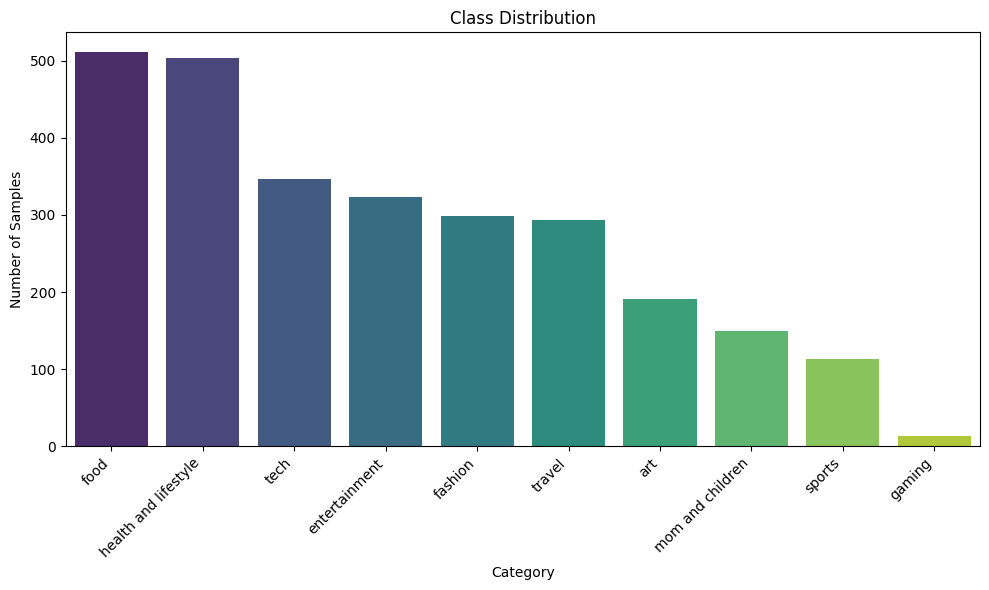


Classes to keep: ['food', 'health and lifestyle', 'tech', 'entertainment', 'fashion', 'travel', 'art', 'mom and children', 'sports']

Total users processed: 2723
Total users skipped: 6


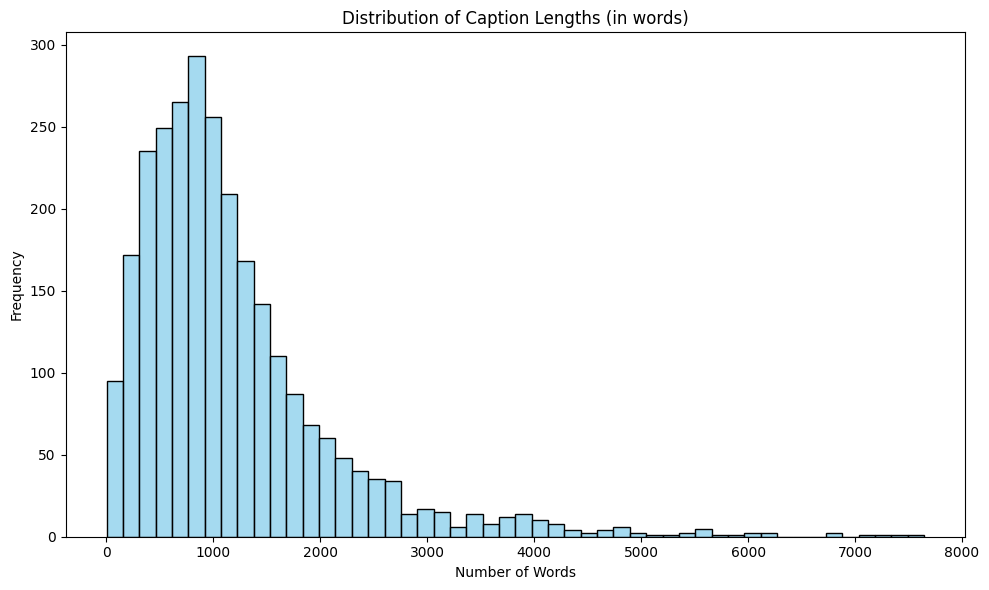

C:\Users\yapra\AppData\Local\Temp\ipykernel_23876\4132426863.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals, y=top_words, palette='coolwarm')


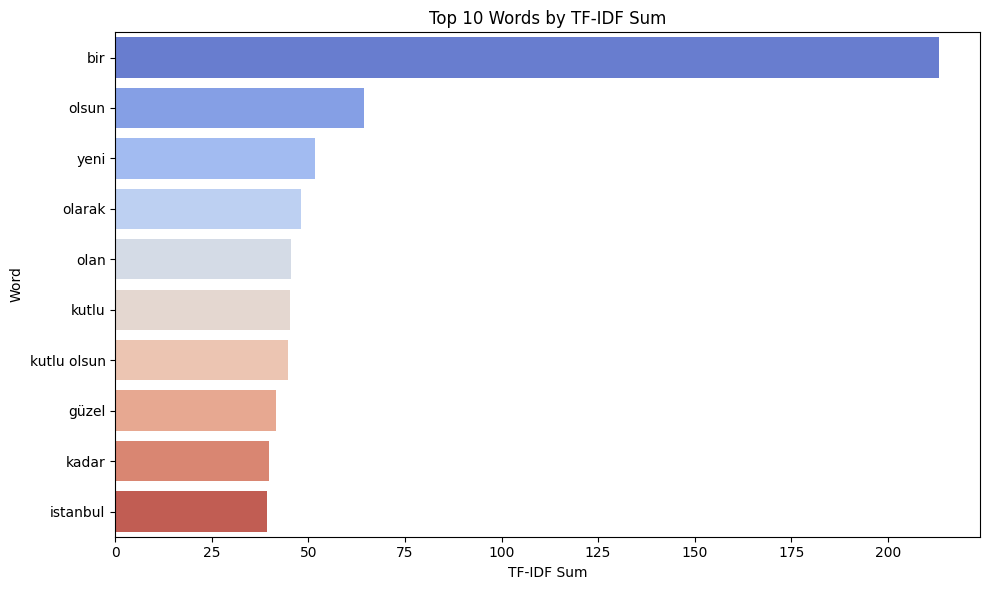


x_train shape: (2178, 5000)
x_val shape: (545, 5000)

After SMOTE:
entertainment           409
food                    409
tech                    409
health and lifestyle    409
mom and children        409
travel                  409
fashion                 409
art                     409
sports                  409
Name: count, dtype: int64

=== Training LogisticRegression ===
Fitting 5 folds for each of 5 candidates, totalling 25 fits
=== LogisticRegression Best Params ===
{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
LR Best CV Accuracy: 0.859302548522211

[Validation - LogisticRegression] Accuracy: 0.6844036697247706
                      precision    recall  f1-score   support

                 art       0.46      0.42      0.44        38
       entertainment       0.54      0.47      0.50        64
             fashion       0.70      0.77      0.73        60
                food       0.85      0.87      0.86       102
health and lifestyle       0.65      0.72      0.68      

<Figure size 1000x600 with 0 Axes>

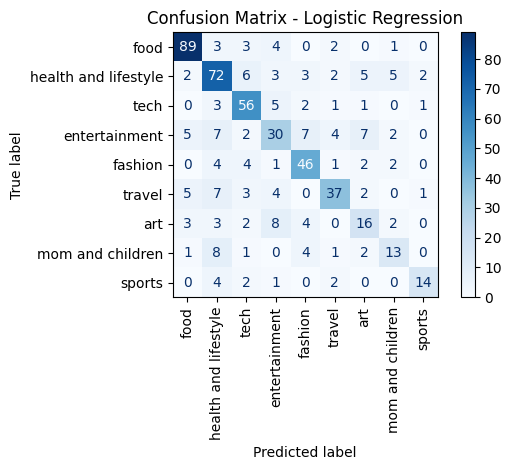


=== Using lr_best Directly for Final Test Predictions ===

All done! Wrote final logistic regression predictions to lr_only_output.json

Note: We skipped retraining on the entire dataset. The 'lr_best' model was used directly.


In [3]:
"""
User Classification with Logistic Regression Only (No Final Retrain)
Author: Your Name
Date: YYYY-MM-DD

This script:
 - Preserves emojis in text preprocessing (does NOT remove punctuation/emojis).
 - Uses TF-IDF for feature extraction, removing both Turkish and English stopwords.
 - Balances classes with SMOTE (applied to the training set only).
 - Trains ONLY a Logistic Regression model via GridSearchCV.
 - **Directly uses the best model** (lr_best) to predict on the test set (no retraining on entire data).
 - Saves final predictions to lr_only_output.json.
"""

# ------------------------------------------------------------------------------
# 1. Import Necessary Libraries
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import json
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# NLTK for Stopwords
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data (if not already)
nltk.download('stopwords')

# ------------------------------------------------------------------------------
# 2. Define Helper Functions
# ------------------------------------------------------------------------------
def normalize_username(username: str) -> str:
    """
    Normalizes the username by stripping leading/trailing spaces and converting to lowercase.
    """
    return username.strip().casefold() if isinstance(username, str) else ""

def preprocess_text(text: str) -> str:
    """
    Cleans and preprocesses the input text by:
    - Lowercasing (casefold)
    - Removing URLs
    - Removing numbers
    - Removing extra whitespaces
    - Does NOT remove emojis or punctuation.
    """
    if not isinstance(text, str):
        return ""
    
    text = text.casefold()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ------------------------------------------------------------------------------
# 3. Define File Paths (Update to Your Environment)
# ------------------------------------------------------------------------------
TRAIN_CLASSIFICATION_CSV = r"C:\Users\yapra\OneDrive\Masaüstü\412P\released_dataset\train-classification.csv"
TRAINING_DATA_JSONL      = r"C:\Users\yapra\OneDrive\Masaüstü\412P\released_dataset\training-dataset.jsonl"
TEST_CLASSIFICATION_LIST = r"C:\Users\yapra\OneDrive\Masaüstü\412P\released_dataset\test-classification-round3.dat"

# ------------------------------------------------------------------------------
# 4. Load and Prepare Classification Labels
# ------------------------------------------------------------------------------
train_classification_df = pd.read_csv(TRAIN_CLASSIFICATION_CSV)

train_classification_df = train_classification_df.rename(
    columns={'Unnamed: 0': 'user_id', 'label': 'category'}
)

train_classification_df["user_id"] = train_classification_df["user_id"].apply(normalize_username)
train_classification_df["category"] = train_classification_df["category"].str.lower()

class_counts = train_classification_df['category'].value_counts()
print("Class Distribution:")
print(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Keep only classes with at least 20 samples
min_samples = 20
classes_to_keep = class_counts[class_counts >= min_samples].index
print("\nClasses to keep:", classes_to_keep.tolist())

filtered_indices = train_classification_df['category'].isin(classes_to_keep)
train_classification_df_filtered = train_classification_df[filtered_indices]

username2_category_filtered = dict(
    zip(train_classification_df_filtered["user_id"], train_classification_df_filtered["category"])
)

# ------------------------------------------------------------------------------
# 5. Load Training and Test Posts
# ------------------------------------------------------------------------------
username2posts_train = {}
username2profile_train = {}
username2posts_test = {}
username2profile_test = {}

with open(TRAINING_DATA_JSONL, "r", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)
        profile = sample.get("profile", {})
        uname = normalize_username(profile.get("username", ""))
        
        if uname in username2_category_filtered:
            username2posts_train[uname] = sample.get("posts", [])
            username2profile_train[uname] = profile
        else:
            username2posts_test[uname] = sample.get("posts", [])
            username2profile_test[uname] = profile

# ------------------------------------------------------------------------------
# 6. Build Training Corpus and Labels
# ------------------------------------------------------------------------------
train_usernames = list(username2_category_filtered.keys())
train_corpus = []
y_train_list = []
missing_users = []

for uname in train_usernames:
    posts = username2posts_train.get(uname, [])
    if not posts:
        print(f"Warning: No posts found for user '{uname}'. Skipping.")
        missing_users.append(uname)
        continue
    
    cleaned_captions = [
        preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "") is not None
    ]
    user_post_captions = "\n".join([cap for cap in cleaned_captions if cap])
    
    if not user_post_captions:
        print(f"Warning: All captions for user '{uname}' are empty after preprocessing. Skipping.")
        missing_users.append(uname)
        continue
    
    train_corpus.append(user_post_captions)
    y_train_list.append(username2_category_filtered[uname])

print(f"\nTotal users processed: {len(train_corpus)}")
print(f"Total users skipped: {len(missing_users)}")

# ------------------------------------------------------------------------------
# 7. Exploratory Visualization: Caption Length Distribution
# ------------------------------------------------------------------------------
caption_lengths = [len(text.split()) for text in train_corpus]
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=50, color='skyblue')
plt.title("Distribution of Caption Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 8. TF-IDF Vectorization (English + Turkish Stopwords)
# ------------------------------------------------------------------------------
turkish_stopwords = stopwords.words('turkish')
english_stopwords = stopwords.words('english')
combined_stopwords = set(turkish_stopwords).union(set(english_stopwords))
combined_stopwords = list(combined_stopwords)  # Convert set -> list

vectorizer = TfidfVectorizer(
    stop_words=combined_stopwords,
    max_features=5000,
    ngram_range=(1, 2)
)
x_post_train = vectorizer.fit_transform(train_corpus)

all_features = vectorizer.get_feature_names_out()
sum_tfidf = x_post_train.sum(axis=0).A1
top_indices = np.argsort(sum_tfidf)[::-1][:10]
top_words = all_features[top_indices]
top_vals = sum_tfidf[top_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_vals, y=top_words, palette='coolwarm')
plt.title("Top 10 Words by TF-IDF Sum")
plt.xlabel("TF-IDF Sum")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

x_post_train_dense = x_post_train.toarray().astype(np.float64)

# ------------------------------------------------------------------------------
# 9. Feature Scaling
# ------------------------------------------------------------------------------
scaler = StandardScaler(with_mean=False)
x_scaled = scaler.fit_transform(x_post_train_dense)
x_scaled = x_scaled.astype(np.float64)
x_scaled[np.isnan(x_scaled)] = 0
x_scaled[np.isinf(x_scaled)] = 0

# ------------------------------------------------------------------------------
# 10. Train/Validation Split
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
x_train, x_val, y_train_, y_val_ = train_test_split(
    x_scaled,
    y_train_list,
    test_size=0.2,
    stratify=y_train_list,
    random_state=42
)
print("\nx_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)

# ------------------------------------------------------------------------------
# 11. Handle Class Imbalance with SMOTE
# ------------------------------------------------------------------------------
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train_)
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())

# ------------------------------------------------------------------------------
# 12. Logistic Regression Training via GridSearchCV
# ------------------------------------------------------------------------------
print("\n=== Training LogisticRegression ===")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    solver='saga',
    random_state=42
)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['saga']
}

grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search_lr.fit(x_train_res, y_train_res)

print("=== LogisticRegression Best Params ===")
from pprint import pprint
pprint(grid_search_lr.best_params_)
print("LR Best CV Accuracy:", grid_search_lr.best_score_)

lr_best = grid_search_lr.best_estimator_

# Evaluate on validation set
y_val_pred_lr = lr_best.predict(x_val)
lr_val_acc = accuracy_score(y_val_, y_val_pred_lr)
print("\n[Validation - LogisticRegression] Accuracy:", lr_val_acc)
print(classification_report(y_val_, y_val_pred_lr, zero_division=0))

cm_lr = confusion_matrix(y_val_, y_val_pred_lr, labels=classes_to_keep)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=classes_to_keep)
plt.figure(figsize=(10, 6))
disp_lr.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 13. **Use lr_best Directly** to Predict on Test (Skip Retraining on Entire Data)
# ------------------------------------------------------------------------------
print("\n=== Using lr_best Directly for Final Test Predictions ===")

# Build test corpus
test_usernames = []
test_corpus = []
for uname, posts in username2posts_test.items():
    test_usernames.append(uname)
    cleaned_captions = [
        preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "") is not None
    ]
    user_post_captions = "\n".join([cap for cap in cleaned_captions if cap])
    test_corpus.append(user_post_captions)

# Vectorize + Scale test data
x_test_tfidf = vectorizer.transform(test_corpus).toarray().astype(np.float64)
x_test_tfidf = scaler.transform(x_test_tfidf)
x_test_tfidf[np.isnan(x_test_tfidf)] = 0
x_test_tfidf[np.isinf(x_test_tfidf)] = 0

test_pred_lr = lr_best.predict(x_test_tfidf)

# Sort outputs by the test-classification list
test_usernames_ordered = []
def normalize_username_list(username_line):
    return username_line.strip().casefold() if username_line else ""

with open(TEST_CLASSIFICATION_LIST, "r", encoding="utf-8") as fh:
    for line in fh:
        line = line.strip()
        if line.lower() == "screenname":
            continue
        if line:
            normalized_uname = normalize_username_list(line)
            test_usernames_ordered.append(normalized_uname)

username2pred_lr = dict(zip(test_usernames, test_pred_lr))

lr_pred_dict = {}
for uname in test_usernames_ordered:
    lr_pred_dict[uname] = username2pred_lr.get(uname, "unknown_label")

LR_OUTPUT_JSON = "lr_only_output.json"
with open(LR_OUTPUT_JSON, "w", encoding="utf-8") as of:
    json.dump(lr_pred_dict, of, indent=4, ensure_ascii=False)

print(f"\nAll done! Wrote final logistic regression predictions to {LR_OUTPUT_JSON}")
print("\nNote: We skipped retraining on the entire dataset. The 'lr_best' model was used directly.")
